### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [336]:
import warnings
warnings.filterwarnings('ignore')

In [337]:
import pandas as pd

In [338]:
news = pd.read_csv("C:\\Users\\Mell\\Desktop\\materials2\\articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [339]:
users = pd.read_csv("C:\\Users\\Mell\\Desktop\\materials2\\users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [340]:
!pip install razdel
!pip install pymorphy2
!pip install gensim

In [341]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [342]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [343]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [344]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [345]:
with open('C:\\Users\\Mell\\Desktop\\materials2\\stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [346]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [347]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 24.1 s


In [348]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 57s


In [406]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [407]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 29 s


In [408]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [409]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(1, 0.2456185),
 (3, 0.043261226),
 (5, 0.34507832),
 (8, 0.1893758),
 (19, 0.087543696),
 (21, 0.07222292)]

In [410]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: ракета экипаж км объект флот комплекс энергия
topic_1: год температура остров писать египет запустить океан
topic_2: ребёнок человек который свой научный год это
topic_3: украина украинский компания доля киев продукция поток
topic_4: год россия рубль млрд это который российский
topic_5: восток страдать законодательство километр климат год хороший
topic_6: тело товар проверка японский северный южный япония
topic_7: nn торговый конкурс участок площадь ноябрь год
topic_8: взрыв вино фаза бежать необычный тур свердловский
topic_9: палата компьютерный курение артист регистрация сочи актёр
topic_10: дело который сотрудник суд это смерть рак
topic_11: это год который мочь исследование свой человек
topic_12: банк год это новый который топливо совет
topic_13: год который это сша американский также первый
topic_14: газ страна сша год президент рост россия
topic_15: террорист сократиться власть боевик город результат человек
topic_16: журнал доллар превысить тыс рекорд производитель гара

In [411]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [412]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.208968,0.018471,0.0,0.0,0.0
1,4896,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.634108,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.171343,0.0,0.0,0.0
2,4897,0.000000,0.245679,0.0,0.043123,0.0,0.346809,0.0,0.0,0.189194,...,0.0,0.0,0.0,0.0,0.087562,0.000000,0.070733,0.0,0.0,0.0
3,4898,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.088935,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.426360,0.0,0.0,0.0
4,4899,0.052015,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.050760,...,0.0,0.0,0.0,0.0,0.000000,0.185375,0.000000,0.0,0.0,0.0


### Следующий шаг - векторные представления пользователей

In [413]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [414]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [415]:
doc_dict[293622]

array([0.        , 0.16413024, 0.1317983 , 0.        , 0.0571767 ,
       0.03049812, 0.        , 0.        , 0.        , 0.08800889,
       0.        , 0.27523538, 0.        , 0.13436948, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01632717,
       0.09274422, 0.        , 0.        , 0.        , 0.        ])

In [416]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [417]:
get_user_embedding(user_articles_list)

array([0.0121223 , 0.01370806, 0.0380699 , 0.00607058, 0.14799097,
       0.01162103, 0.        , 0.05374806, 0.00345559, 0.        ,
       0.12990673, 0.17947291, 0.02766846, 0.10448873, 0.1134307 ,
       0.        , 0.00322665, 0.        , 0.        , 0.        ,
       0.07273309, 0.03100608, 0.03698351, 0.        , 0.00302261])

In [418]:
#users['articles'].iloc[33]

In [419]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

In [420]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.083630,0.127426,0.063809,0.026211,0.016374,0.003541,0.041182,0.003819,...,0.012479,0.0,0.007013,0.0,0.002721,0.206811,0.054254,0.000000,0.003741,0.018247
1,u108690,0.001697,0.014173,0.055802,0.058919,0.073316,0.009914,0.015454,0.009015,0.000000,...,0.006531,0.0,0.014589,0.0,0.001840,0.103153,0.068866,0.021505,0.000000,0.018798
2,u108339,0.000000,0.017604,0.076363,0.008323,0.061720,0.004404,0.009092,0.031878,0.000000,...,0.026043,0.0,0.000000,0.0,0.000000,0.159508,0.027889,0.023507,0.000000,0.042308


In [421]:
target = pd.read_csv("C:\\Users\\Mell\\Desktop\\materials2\\users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [422]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.083630,0.127426,0.063809,0.026211,0.016374,0.003541,0.041182,0.003819,...,0.0,0.007013,0.0,0.002721,0.206811,0.054254,0.000000,0.003741,0.018247,0
1,u108690,0.001697,0.014173,0.055802,0.058919,0.073316,0.009914,0.015454,0.009015,0.000000,...,0.0,0.014589,0.0,0.001840,0.103153,0.068866,0.021505,0.000000,0.018798,1
2,u108339,0.000000,0.017604,0.076363,0.008323,0.061720,0.004404,0.009092,0.031878,0.000000,...,0.0,0.000000,0.0,0.000000,0.159508,0.027889,0.023507,0.000000,0.042308,1


In [423]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [424]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [425]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [426]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.24502468, 0.07529445, 0.41338083, 0.28572085, 0.006935  ,
       0.05165523, 0.16034737, 0.05665506, 0.0585055 , 0.13076895])

In [427]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [428]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))

Best Threshold=0.230993, F-Score=0.672, Precision=0.578, Recall=0.804


In [429]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1755    0]
 [ 244    1]]


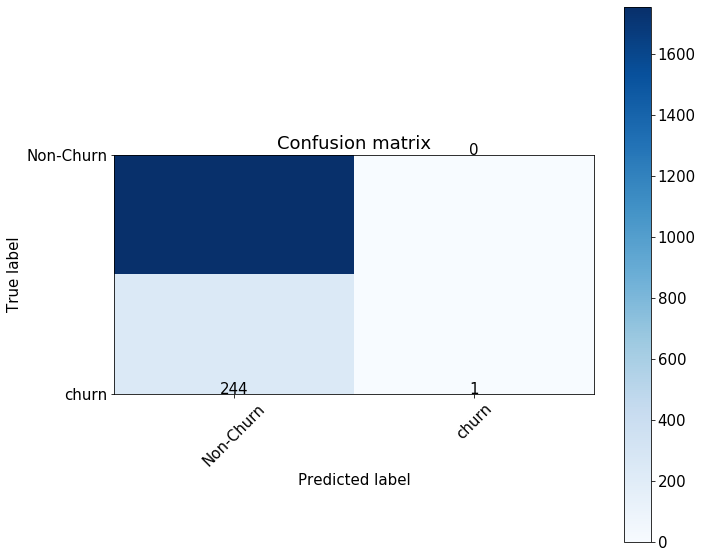

In [430]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [431]:
roc_auc_score(y_test, preds)

0.9498738298738298

**2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)**

In [432]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [433]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [434]:
X = pd.merge(user_embeddings_median, target, 'left')

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [436]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [437]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.3232741 , 0.03541496, 0.70946391, 0.44632519, 0.01916004,
       0.06363326, 0.19201458, 0.17872764, 0.0496313 , 0.1435748 ])

In [438]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold=0.281611, F-Score=0.750, Precision=0.704, Recall=0.804


In [439]:
roc_auc_score(y_test, preds)

0.9709029594743881

**3. Повторить п.2, но используя уже не медиану, а max**

In [440]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [441]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [442]:
X = pd.merge(user_embeddings_max, target, 'left')

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [444]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [445]:
preds = logreg.predict_proba(X_test)[:, 1]

In [446]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold=0.347441, F-Score=0.801, Precision=0.814, Recall=0.788


In [447]:
roc_auc_score(y_test, preds)

0.9742357113785686

**4.(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.**

In [448]:
users_idf = pd.read_csv("C:\\Users\\Mell\\Desktop\\materials2\\users_articles.csv")

In [449]:
users_idf['articles'] = users_idf['articles'].apply(lambda x: "".join([i.strip() for i in x.replace("[","").replace("]","")]),1)

In [450]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(users_idf['articles'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [451]:
idf = pd.DataFrame({'art_id': tfidf.get_feature_names(),
             'idf': tfidf.idf_})

In [452]:
idf_d = dict(zip(idf['art_id'].values, idf['idf'].values))

In [453]:
def get_user_embedding_idf(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id]*idf_d[f'{doc_id}'] for doc_id in user_articles_list if str(doc_id) in idf_d])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [454]:
user_embeddings_idf = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_idf(x), 1)])
user_embeddings_idf.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_idf['uid'] = users['uid'].values
user_embeddings_idf = user_embeddings_idf[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [455]:
X = pd.merge(user_embeddings_idf, target, 'left')

In [456]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [457]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [458]:
preds = logreg.predict_proba(X_test)[:, 1]

In [459]:
precision_idf, recall_idf, thresholds_idf = precision_recall_curve(y_test, preds)
fscore_idf = (2 * precision_idf * recall_idf) / (precision_idf + recall_idf)
# locate the index of the largest f score
ix = np.argmax(fscore_idf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_idf[ix], 
                                                                        fscore_idf[ix],
                                                                        precision_idf[ix],
                                                                        recall_idf[ix]))

Best Threshold=0.354882, F-Score=0.801, Precision=0.782, Recall=0.820


In [460]:
roc_auc_score(y_test, preds)

0.9776405604977034

In [471]:
mean_res = [precision_mean[ix], recall_mean[ix],fscore_mean[ix]]
median_res = [precision_median[ix], recall_median[ix],fscore_median[ix]]
max_res = [precision_max[ix], recall_max[ix],fscore_max[ix]]
idf_res= [precision_idf[ix], recall_idf[ix],fscore_idf[ix]]

In [478]:
results = pd.DataFrame({'mean': mean_res,
                        'median': median_res,
                        'max': max_res,
                        'idf': idf_res}).T
results.columns=['precision', 'recall','f1_score']
#забыл сохранить roc_auc в отдельные переменные..
results['roc_auc_score'] = [0.9498738298738298,0.9709029594743881,0.9742357113785686,0.9776405604977034]

In [479]:
results

,precision,recall,f1_score,roc_auc_score
mean,0.435424,0.963265,0.599746,0.949874
median,0.651652,0.885714,0.750865,0.970903
max,0.314839,0.995918,0.478431,0.974236
idf,0.782101,0.820408,0.800797,0.977641


Использование медианы и максимального значения (на удивление) - повысили точность модели. Добавление IDF, при этом использовав усреднение показало наилучший результат.